# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    install_options = get_yaml(name, installfile)
    result['stochastic_cpu'] = install_options['stochastic_cpu']
    result['polynomial_dgemm'] = install_options['polynomial_dgemm']
    return result

simulation_dir = 'paper_sc19/performance/1/'
simulation_files = [simulation_dir + f for f in os.listdir(simulation_dir)]

reality_files = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
]
dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfreal = pandas.concat([read_result(f) for f in reality_files])
dfsim['mode'] = 'simulation'
dfreal['mode'] = 'reality'
df = pandas.concat([dfsim, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,gflops,...,process_per_node,residual,rfact,simulation_time,stochastic_cpu,swap,sys_time,thread_per_process,time,usr_time
0,386.028,2,128,0.99,1,42.0,42.0,42.0,42.0,23980.0,...,32,NaN,2,3140.860,False,0,470.17,1,149.02,2667.38
1,1088.090,2,128,0.99,1,42.0,42.0,42.0,42.0,28870.0,...,32,NaN,2,12834.300,False,0,3024.32,1,2886.43,9785.78
2,110.867,2,128,1.00,1,42.0,42.0,42.0,42.0,14010.0,...,32,NaN,2,754.427,False,0,57.40,1,5.95,700.41
3,665.613,2,128,0.99,1,42.0,42.0,42.0,42.0,26980.0,...,32,NaN,2,6381.750,False,0,1325.68,1,667.07,5045.12
4,845.144,2,128,0.99,1,42.0,42.0,42.0,42.0,28150.0,...,32,NaN,2,9278.660,False,0,1947.20,1,1515.50,7312.16


### Checking the parameters

In [2]:
dfsim[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,42.0,42.0,42.0,42.0


In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'platform',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,bcast,rfact,depth,block_size,thread_per_process,proc_p,proc_q,process_per_node,mem_align,swap,pfact
0,2,2,1,128,1,32,32,32,8,0,1


In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files] # I changed the platform in this new simulation, calls to SMPI_Wtime now do not take time
# platforms = [zipfile.ZipFile(f).read('dahu.xml').decode('ascii') for f in (simulation_files + simulation_files_old)]
platforms = list(set(platforms))
assert(len(platforms)) == 2
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### dahu_old.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;63305:129.24904864614737"/>
        <prop id="smpi/async-small-thresh" value="8133"/>
        <prop id="smpi/send-is-detached-thresh" value="8133"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.10us" loopback_bw="18.348422228142724GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [5]:
patches = {}
for archive in simulation_files:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    install_options = get_yaml(archive, installfile)
    stochastic_cpu = install_options['stochastic_cpu']
    polynomial_dgemm = install_options['polynomial_dgemm']
    repos = get_yaml(archive, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    try:
        patches[(stochastic_cpu, polynomial_dgemm)].add(hpl[0]['patch'])
    except KeyError:
        patches[(stochastic_cpu, polynomial_dgemm)] = {(hpl[0]['patch'])}
for (stochastic_cpu, polynomial_dgemm), patch in patches.items():
    assert len(patch) == 1
    display(Markdown('### stochastic_cpu=%s  |  polynomial_dgemm=%s' % (stochastic_cpu, polynomial_dgemm)))
    display(Markdown('```diff\n%s\n```' % patch.pop()))

### stochastic_cpu=False  |  polynomial_dgemm=True

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index 0119820..dfe826c 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -144,6 +144,7 @@ double random_halfnormal(void) {
 double random_halfnormal_shifted(double exp, double std) {
     // Here, exp and std are the desired expectation and standard deviation.
     // We compute the corresponding mu and sigma parameters for the normal distribution.
+    return exp;
     double mu, sigma;
     sigma = std/sqrt(1-2/M_PI);
     mu = exp - sigma*sqrt(2/M_PI);
    
```

### stochastic_cpu=True  |  polynomial_dgemm=True

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 
```

### stochastic_cpu=False  |  polynomial_dgemm=False

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index 0119820..dfe826c 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -144,6 +144,7 @@ double random_halfnormal(void) {
 double random_halfnormal_shifted(double exp, double std) {
     // Here, exp and std are the desired expectation and standard deviation.
     // We compute the corresponding mu and sigma parameters for the normal distribution.
+    return exp;
     double mu, sigma;
     sigma = std/sqrt(1-2/M_PI);
     mu = exp - sigma*sqrt(2/M_PI);
    

diff --git a/include/hpl_blas.h b/include/hpl_blas.h
index 35dea84..3803d8c 100644
--- a/include/hpl_blas.h
+++ b/include/hpl_blas.h
@@ -214,7 +214,7 @@ static double dtrsm_intercept = -1;
     double mn =  (double)(M) * (double)(N);\
     double mk =  (double)(M) * (double)(K);\
     double nk =  (double)(N) * (double)(K);\
-    double raw_duration = 2.844700e-07 + 6.317136e-11*mnk + 1.489053e-10*mn + 2.107985e-09*mk + 3.332944e-09*nk;\
+    double raw_duration = 6.484604e-11*mnk + 1e-6;\
     double sigma = 1.087202e-07 + 2.976703e-12*mnk + 8.365868e-12*mn + 1.528598e-10*mk + 9.931248e-11*nk;\
     double noise = random_halfnormal_shifted(0, sigma);\
     double injected_duration = raw_duration + noise;\
    
```

### stochastic_cpu=True  |  polynomial_dgemm=False

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/include/hpl_blas.h b/include/hpl_blas.h
index 35dea84..3803d8c 100644
--- a/include/hpl_blas.h
+++ b/include/hpl_blas.h
@@ -214,7 +214,7 @@ static double dtrsm_intercept = -1;
     double mn =  (double)(M) * (double)(N);\
     double mk =  (double)(M) * (double)(K);\
     double nk =  (double)(N) * (double)(K);\
-    double raw_duration = 2.844700e-07 + 6.317136e-11*mnk + 1.489053e-10*mn + 2.107985e-09*mk + 3.332944e-09*nk;\
+    double raw_duration = 6.484604e-11*mnk + 1e-6;\
     double sigma = 1.087202e-07 + 2.976703e-12*mnk + 8.365868e-12*mn + 1.528598e-10*mk + 9.931248e-11*nk;\
     double noise = random_halfnormal_shifted(0, sigma);\
     double injected_duration = raw_duration + noise;\
    
```

### Comparing the simulation with the real execution

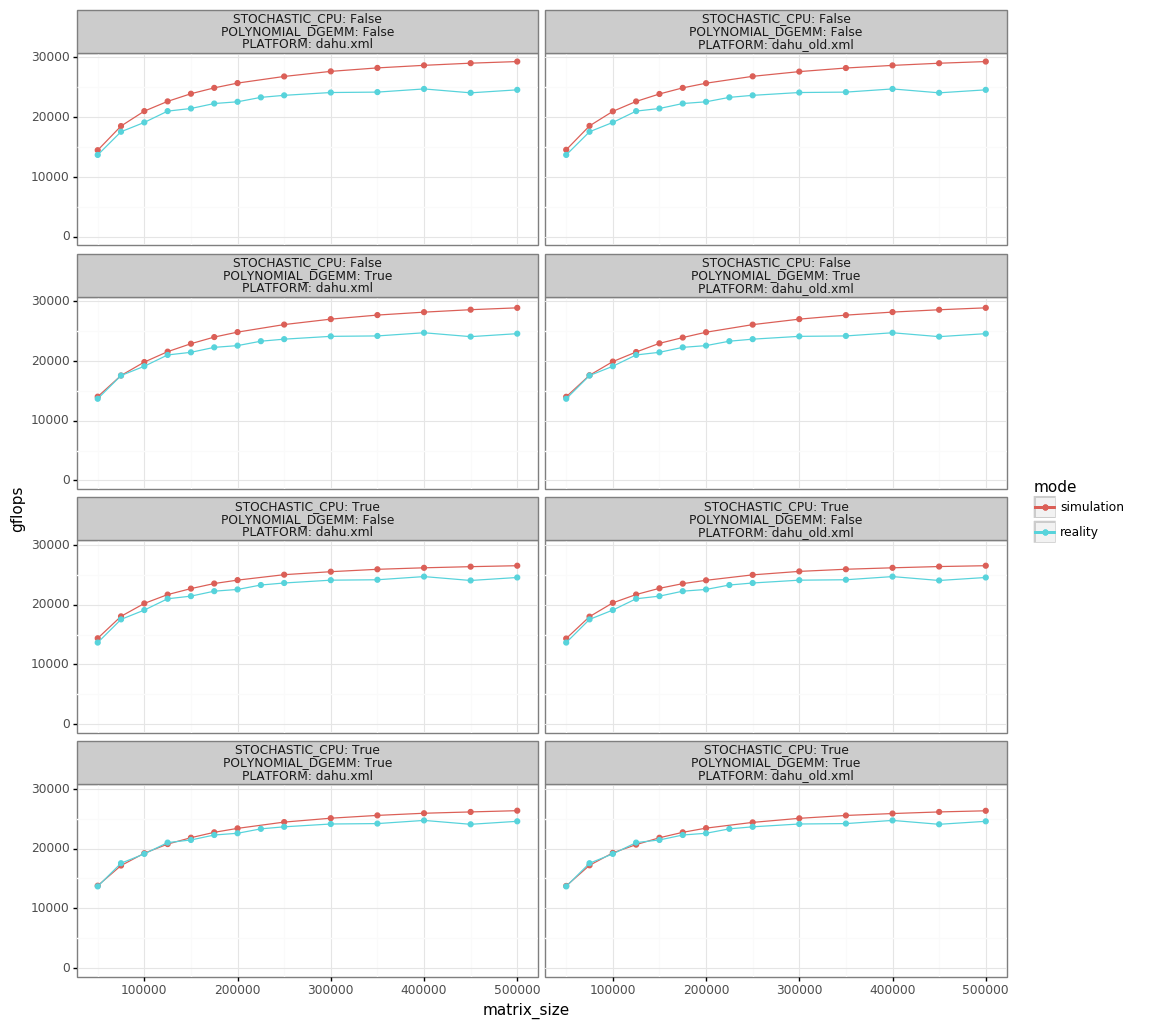

<ggplot: (-9223363258969443619)>

In [6]:
import numpy
plotnine.options.figure_size = (12, 12)

factors = ['stochastic_cpu', 'polynomial_dgemm', 'platform']
new_factors = [f.upper() for f in factors]
for old, new in zip(factors, new_factors):
    dfsim[new] = dfsim[old]

plot = ggplot(dfsim, aes(x='matrix_size', y='gflops', color='mode')) + theme_bw() + expand_limits(y=0)
plot = plot + geom_point() + stat_summary(fun_y = numpy.mean, geom='line')
plot = plot + geom_point(dfreal[['matrix_size', 'gflops', 'mode']]) + stat_summary(dfreal[['matrix_size', 'gflops', 'mode']], fun_y = numpy.mean, geom='line')
plot = plot + facet_wrap(new_factors, labeller='label_both', nrow=4)
plot

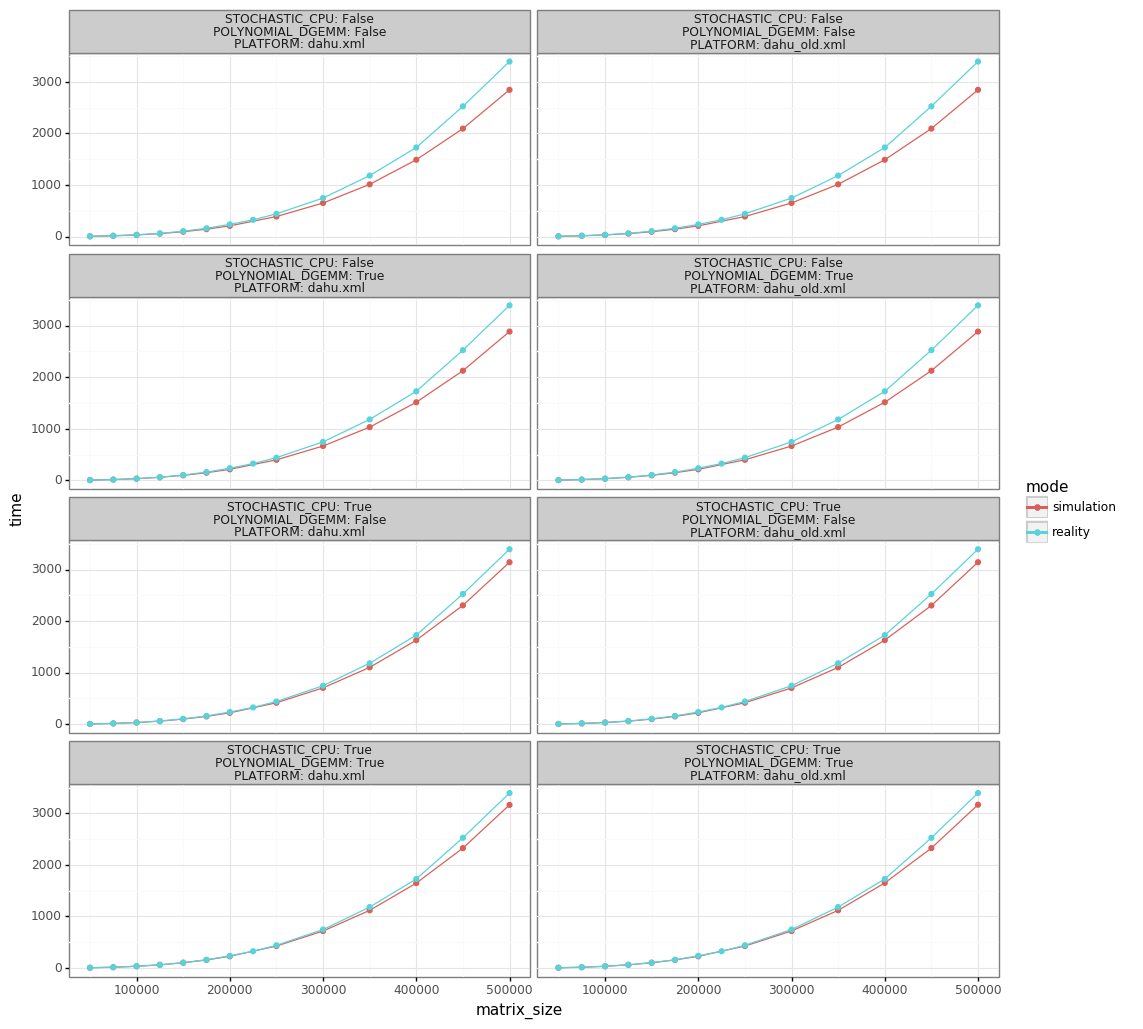

<ggplot: (-9223363258970771726)>

In [7]:
plot = ggplot(dfsim, aes(x='matrix_size', y='time', color='mode')) + theme_bw() + expand_limits(y=0)
plot = plot + geom_point() + stat_summary(fun_y = numpy.mean, geom='line')
plot = plot + geom_point(dfreal[['matrix_size', 'time', 'mode']]) + stat_summary(dfreal[['matrix_size', 'time', 'mode']], fun_y = numpy.mean, geom='line')
plot = plot + facet_wrap(new_factors, labeller='label_both', nrow=4)
plot

Let's keep the experiments with the new platform file and with either a simple model (deterministic and linear) or a complex model (stochastic and polynomial).

In [8]:
tmp1 = dfsim[(~dfsim['stochastic_cpu']) & (~dfsim['polynomial_dgemm']) & (dfsim['platform'] == 'dahu.xml')].copy()
tmp2 = dfsim[( dfsim['stochastic_cpu']) & ( dfsim['polynomial_dgemm']) & (dfsim['platform'] == 'dahu.xml')].copy()
tmp1['mode'] = 'simulation:simple'
tmp2['mode'] = 'simulation:complex'
df = pandas.concat([dfreal, tmp1, tmp2])
dfsim = tmp2

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 12 x 8 in image.
  from_inches(height, units), units))
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /tmp/validation_performance.pdf
  warn('Filename: {}'.format(filename))


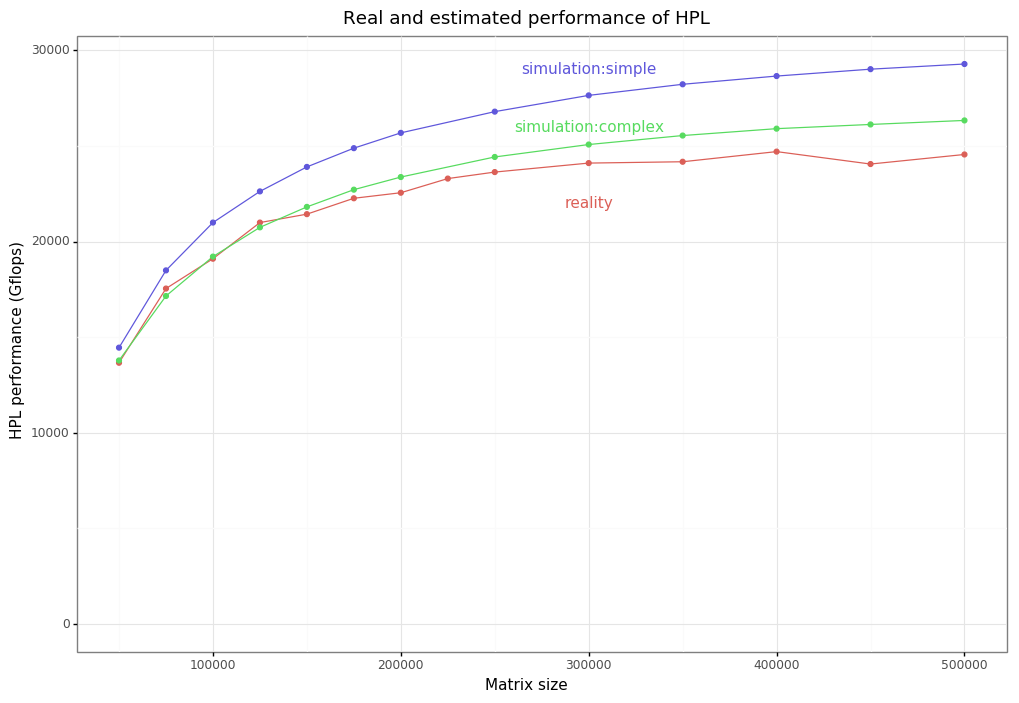

<ggplot: (8777884007316)>

In [9]:
plotnine.options.figure_size = (12, 8)

# Computing the coordinates for the text...
tmp = pandas.DataFrame({
    'mode': ['reality', 'simulation:complex', 'simulation:simple'],
    'matrix_size': [3e5]*3,
    'gflops': [2.2e4, 2.6e4, 2.9e4]
})

plot = ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)
plot = plot + xlab('Matrix size') + ylab('HPL performance (Gflops)') + ggtitle('Real and estimated performance of HPL')
plot = plot + geom_text(tmp, aes(x = 'matrix_size', y = 'gflops', color = 'mode', label='mode')) + scale_color_discrete(guide=False)
plot.save('/tmp/validation_performance.pdf')
plot

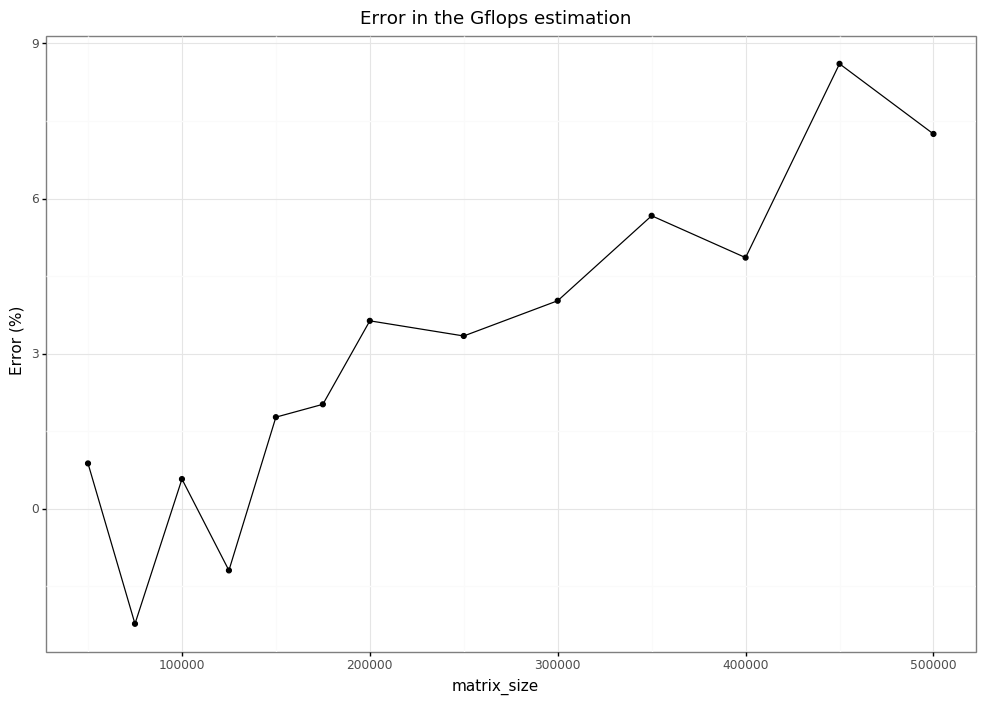

<ggplot: (-9223363258970797964)>

In [10]:
tmp = dfsim.set_index('matrix_size').join(dfreal.set_index('matrix_size'), rsuffix='_real').reset_index()
tmp['error'] = (tmp.gflops - tmp.gflops_real) / tmp.gflops_real * 100
tmp = tmp[~tmp.error.isna()]
ggplot(tmp, aes(x='matrix_size', y='error')) + geom_line() + geom_point() + ylab('Error (%)') + ggtitle('Error in the Gflops estimation') + theme_bw()

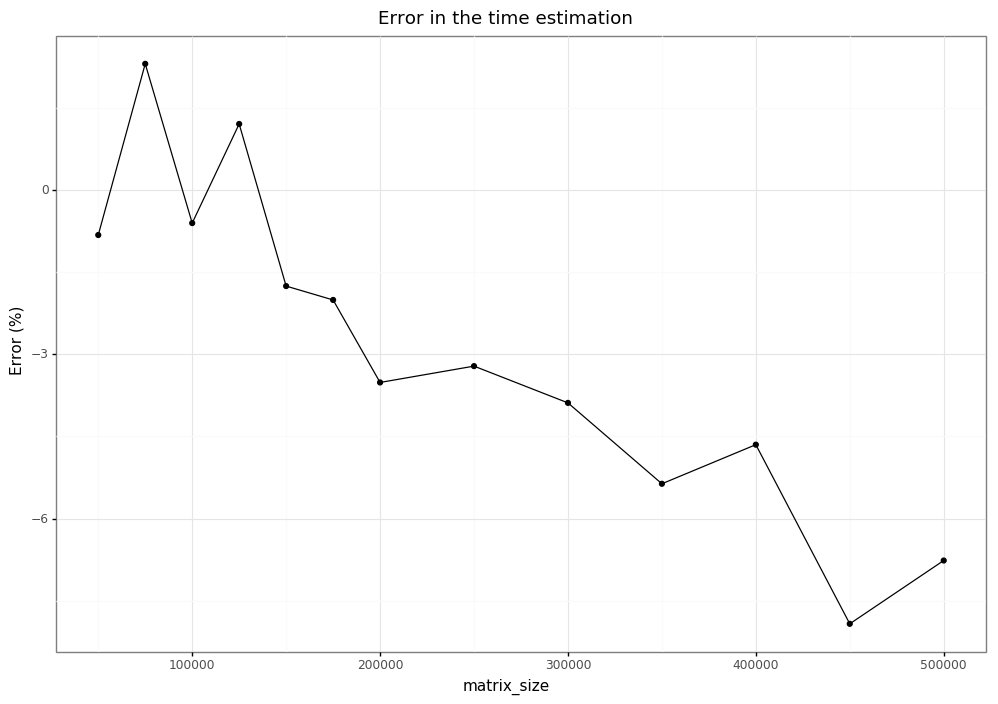

<ggplot: (-9223363259005597710)>

In [11]:
tmp['error'] = (tmp.time - tmp.time_real) / tmp.time_real * 100
tmp = tmp[~tmp.error.isna()]
ggplot(tmp, aes(x='matrix_size', y='error')) + geom_line() + geom_point() + ylab('Error (%)') + ggtitle('Error in the time estimation') + theme_bw()

### Efficiency of the simulation

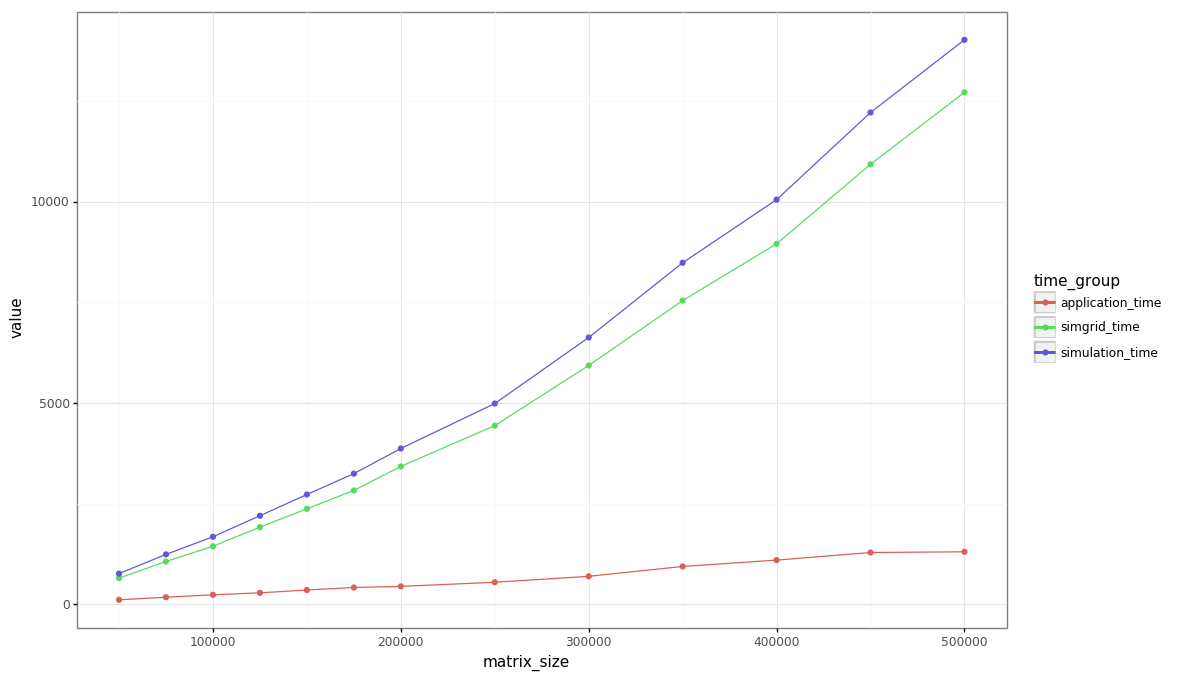

<ggplot: (8777848940885)>


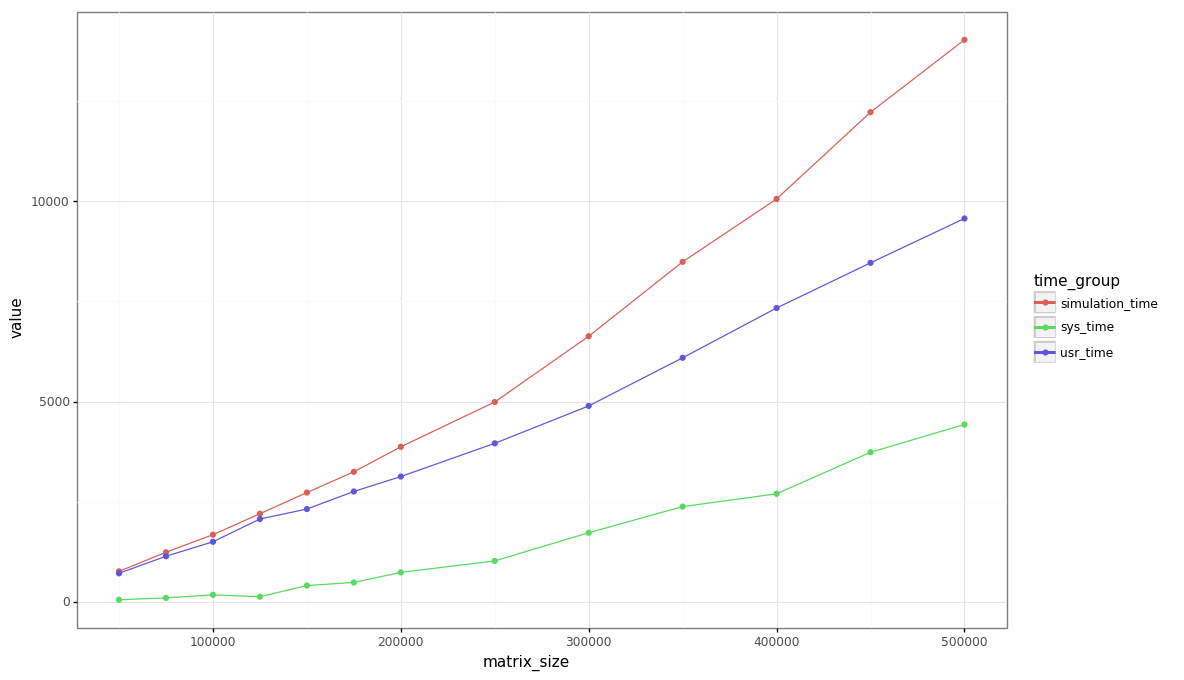

<ggplot: (-9223363259006235206)>

In [12]:
dfsim['simgrid_time'] = dfsim.simulation_time - dfsim.application_time

print(ggplot(dfsim.melt(id_vars=['matrix_size'], value_vars=['simulation_time', 'application_time', 'simgrid_time'], var_name='time_group'),
       aes(x='matrix_size', y='value', color='time_group')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw())

ggplot(dfsim.melt(id_vars=['matrix_size'], value_vars=['simulation_time', 'usr_time', 'sys_time'], var_name='time_group'),
       aes(x='matrix_size', y='value', color='time_group')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw()

### Maximum performance

In [13]:
dfsim[dfsim.gflops == dfsim.gflops.max()]

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,gflops,...,swap,sys_time,thread_per_process,time,usr_time,mode,STOCHASTIC_CPU,POLYNOMIAL_DGEMM,PLATFORM,simgrid_time
1,1305.02,2,128,0.99,1,42.0,42.0,42.0,42.0,26330.0,...,0,4426.83,1,3164.55,9568.2,simulation:complex,True,True,dahu.xml,12721.18


In [14]:
dfreal[dfreal.gflops == dfreal.gflops.max()]

,bcast,block_size,depth,gflops,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time,mode
2,2,128,1,24700.0,400000,8,1,32,32,32,0.000531,2,0,1,1727.64,reality
